# Development Notebook
to test codes and functions

* Data Ref: https://note.com/natsunonukegara0/m/md7e3a708fc87

## Test functions related with OpenAI API key

In [84]:
API_KEY_PATH = r"C:\Users\Issei\Documents\API Tokens\ChatGPT.txt"

In [85]:
# Function: Connect to the OpenAI API
def ConnectToOpenAI(key_path=None):
    """
    Connect to the OpenAI API
    key_path is the path to the file containing the API key (Make sure to have the API key in a .txt file and saved locally)
    """
    from openai import OpenAI
    import json
    with open(key_path, 'r') as file:
        API_KEY = file.read().rstrip()
    client = OpenAI(api_key=API_KEY)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a program checkpoint to make sure the API is working."},
            {"role": "user", "content": "Do you see this? If so, say API is working, Hello World!"},
        ]
    )
    print(response.choices[0].message.content)
    return client

In [86]:
client = ConnectToOpenAI(API_KEY_PATH)

API is working, Hello World!


In [87]:
# Function: Send a doucuments to be summarized and return summarized text
def SummarizeDocument(client, document):
    """
    Summarize a document using the OpenAI API
    client: is client object from OpenAI API, use ConnectToOpenAI() to get client object
    document: is the text(str) to be summarized
    """
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system",
             "content": """
                        You are a professional summarizer. You will be given a document to summarize from the user.
                        Instruction as follows: Input and out put is in Japanese. Summarize the doucument around 100 letters. 
                        After summarize, count the number of summarized letters, if it is exceed 100 letters or less than 70 letters, summarize again.
                        Output Format: Only output the final summarized text.
                        """},
            {"role": "user", "content": document},
        ]
    )
    return response.choices[0].message.content

* Prompt 1

"""
                        You are a professional summarizer. You will be given a document to summarize from the user.
                        Instruction as follows: Input and out put is in Japanese. Summarize the doucument around 100 letters. 
                        After summarize, count the number of summarized letters, if it is exceed 100 letters, summarize again.
                        """

MeCabを使ってトークナイゼーションを行う

In [88]:
import fugashi
from rouge_score.tokenizers import Tokenizer

class MeCabTokenizer(Tokenizer):
    def __init__(self, use_stemmer=False):
        self._stemmer = use_stemmer
        
        self.tagger = fugashi.Tagger()
        self.wakati = fugashi.Tagger("-Owakati")

    def tokenize(self, text):
        if self._stemmer:
            node = self.tagger.parseToNode(text)
            original_forms = []
            while node:
                feature = node.feature.split(",")
                original_forms.append(feature[6])
                node = node.next

            return original_forms
        
        else:
            return self.wakati.parse(text).split()

In [89]:
# Function: Calulate ROUGE score with reference
def CalculateROUGE(reference, summary):
    """
    Calculate ROUGE score with reference
    reference: is the reference summary
    summary: is the summary to be evaluated, both in str format
    """
    mecab_tokenizer = MeCabTokenizer()
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=mecab_tokenizer)
    scores = scorer.score(reference, summary)
    return scores

In [90]:
example1 = "一般的に「貧困」と言えば、それには大きく二つの場合がある。一つは絶対的貧困で、もう一つが相対的貧困である。しかし、現代日本社会にはそのほかに「文化的貧困」があるとされ、問題視されている。なお絶対的貧困とは生命を維持するために最低限必要な衣食住が満ち足りていない状態のことを指す。主に発展途上国に見られる貧困であり、飢餓で苦しむ人々やストリートチルドレン等がこれに該当する。一方、相対的貧困とは社会の構成員として「あたりまえの生活」を営むのに必要な水準を欠いている状態のことを指す。憲法二五条「健康で文化的な最低限度の生活」を保てていない状態がこれに該当する。しかし、それらとは別に現代には「文化的貧困」というものがある。例えば、経済的に貧しい若者の中には「貧乏だからコンビニ弁当しか食べられない」と言う者がいる。昔であれば、貧乏ならご飯とみそ汁だけで食いつないだものだ。もしくはそれに似たようなものを「自炊」してどうにか切り抜けたものである。どう考えても、今よりも昔のほうが貧乏の度合いは高い。むしろ昔の状況下においては、今の「コンビニ弁当」は非常に高価なものとさえ言えよう。にもかかわらず、「コンビニ弁当しか食べられない」状況を一部の現代人は「貧乏」と言う。すなわち、これは心もしくは感性の貧困なのである。豊かさの感覚がわからない心。他者依存的に豊かさを求めようとする心。「貧乏だからコンビニ弁当しか食べられない」という一言から、そのような少々ねじれた心的状態すなわち文化状況を指摘することができる。そうすると、憲法二五条「健康で文化的な最低限度の生活」は土台から成立しないことになる。なぜなら、すでに「文化」が貧しいのだから。"

In [91]:
ref1 = "現代社会には絶対的貧困と相対的貧困のほかに文化的貧困がある。それは他者依存的に豊かさを求める、ねじれた文化状況の中の心の貧困である。ゆえに現代では「健康で文化的な最低限度の生活」が土台から成立しない。"

In [92]:
summary = SummarizeDocument(client, example1)
print(summary)

現代日本では絶対的貧困と相対的貧困に加え、文化的貧困が問題視される。これは、心や感性が貧しく、「コンビニ弁当しか食べられない」ことを貧困と感じる状況を指し、憲法が保障する生活の基盤を失わせる。


In [93]:
CalculateROUGE(ref1, summary)

{'rouge1': Score(precision=0.5, recall=0.44776119402985076, fmeasure=0.4724409448818898),
 'rouge2': Score(precision=0.1864406779661017, recall=0.16666666666666666, fmeasure=0.176),
 'rougeL': Score(precision=0.36666666666666664, recall=0.3283582089552239, fmeasure=0.3464566929133858)}

In [94]:
scores = CalculateROUGE(ref1, summary)

In [95]:
scores.values()

dict_values([Score(precision=0.5, recall=0.44776119402985076, fmeasure=0.4724409448818898), Score(precision=0.1864406779661017, recall=0.16666666666666666, fmeasure=0.176), Score(precision=0.36666666666666664, recall=0.3283582089552239, fmeasure=0.3464566929133858)])

In [96]:
# Extract precision, recall, and F1 score in float format
scores['rouge1'].recall

0.44776119402985076

In [103]:
# Plot ROUGE score
import matplotlib.pyplot as plt
import numpy as np

def PlotROUGEScore(scores):
    """
    Plot ROUGE score
    scores: is the ROUGE score in dict format
    """
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].bar(scores.keys(), [scores['rouge1'].precision, scores['rouge1'].recall, scores['rouge1'].fmeasure], color=['red', 'orange', 'blue'])
    ax[0].set_title('ROUGE-1')
    ax[0].set_ylim(0, 1)
    ax[1].bar(scores.keys(), [scores['rouge2'].precision, scores['rouge2'].recall, scores['rouge2'].fmeasure], color=['red', 'orange', 'blue'])
    ax[1].set_title('ROUGE-2')
    ax[1].set_ylim(0, 1)
    ax[2].bar(scores.keys(), [scores['rougeL'].precision, scores['rougeL'].recall, scores['rougeL'].fmeasure], color=['red', 'orange', 'blue'])
    ax[2].set_title('ROUGE-L')
    ax[2].set_ylim(0, 1)
    return fig

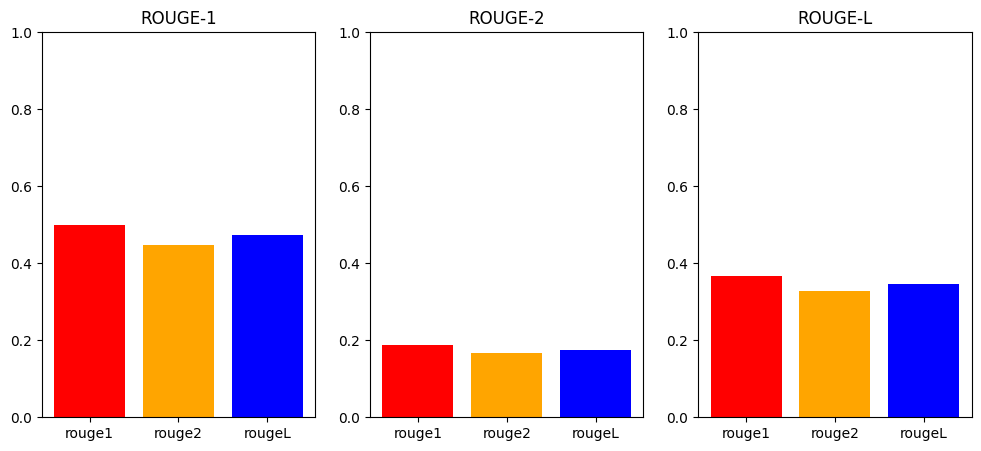

In [98]:
PlotROUGEScore(CalculateROUGE(ref1, summary))

In [101]:
# Function: read text file
def ReadTextFile(file_path):
    """
    Read text file in Japanese
    file_path: is the path to the text file
    """
    with open(file_path, 'r', encoding="utf-8") as file:
        text = file.read()
    return text

In [120]:
# For loop to summarize multiple documents
client = ConnectToOpenAI(API_KEY_PATH)

for i in range(0, 2):
    # Read document and reference
    document_path = "Data/doc/doc-" + str(i) + ".txt"
    ref_path = "Data/ref/ref-" + str(i) + ".txt"
    document = ReadTextFile(document_path)
    reference = ReadTextFile(ref_path)

    # summed ROUGE score in rouge_score format
    summed_ROUGE = {
    'rouge1': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
    'rouge2': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
    'rougeL': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}
    }

    # Suumarize document
    summary = SummarizeDocument(client, document)
    print(i, summary) # Check the summary

    # Calculate ROUGE score
    scores = CalculateROUGE(reference, summary)
    print(scores)

    # Save ROUGE score plot
    plot = PlotROUGEScore(scores)
    plot.savefig("Data/plot/plot-" + str(i) + ".png")
    plt.close()

    # Save summary
    with open("Data/sum/sum-" + str(i) + ".txt", 'w') as file:
        file.write(summary)
    print("Done with", i)

    # sum up ROUGE scores for each document
    summed_ROUGE['rouge1']['precision'] += scores['rouge1'].precision
    summed_ROUGE['rouge1']['recall'] += scores['rouge1'].recall
    summed_ROUGE['rouge1']['fmeasure'] += scores['rouge1'].fmeasure
    summed_ROUGE['rouge2']['precision'] += scores['rouge2'].precision
    summed_ROUGE['rouge2']['recall'] += scores['rouge2'].recall
    summed_ROUGE['rouge2']['fmeasure'] += scores['rouge2'].fmeasure
    summed_ROUGE['rougeL']['precision'] += scores['rougeL'].precision
    summed_ROUGE['rougeL']['recall'] += scores['rougeL'].recall
    summed_ROUGE['rougeL']['fmeasure'] += scores['rougeL'].fmeasure

API is working, Hello World!
0 現代日本では、「文化的貧困」が問題視されている。これは経済的に貧しい若者が「貧乏だからコンビニ弁当しか食べられない」と感じる状況からも明らかで、感性の貧困が原因とされる。これは豊かさの感覚がわからず、他者依存的に豊かさを求める心の状態を指し、憲法での「文化的な最低限度の生活」を土台から成立させない問題として浮上している。
{'rouge1': Score(precision=0.4528301886792453, recall=0.7164179104477612, fmeasure=0.5549132947976879), 'rouge2': Score(precision=0.21904761904761905, recall=0.3484848484848485, fmeasure=0.26900584795321636), 'rougeL': Score(precision=0.330188679245283, recall=0.5223880597014925, fmeasure=0.40462427745664736)}
Done with 0
1 英語は世界共通語として重要ですが、「英語帝国主義」によるハンディキャップや表現の限界もあります。日本語の概念を英語で説明する困難さや英語支配の問題が指摘されています。
{'rouge1': Score(precision=0.5, recall=0.4406779661016949, fmeasure=0.4684684684684685), 'rouge2': Score(precision=0.11764705882352941, recall=0.10344827586206896, fmeasure=0.11009174311926605), 'rougeL': Score(precision=0.28846153846153844, recall=0.2542372881355932, fmeasure=0.27027027027027023)}
Done with 1


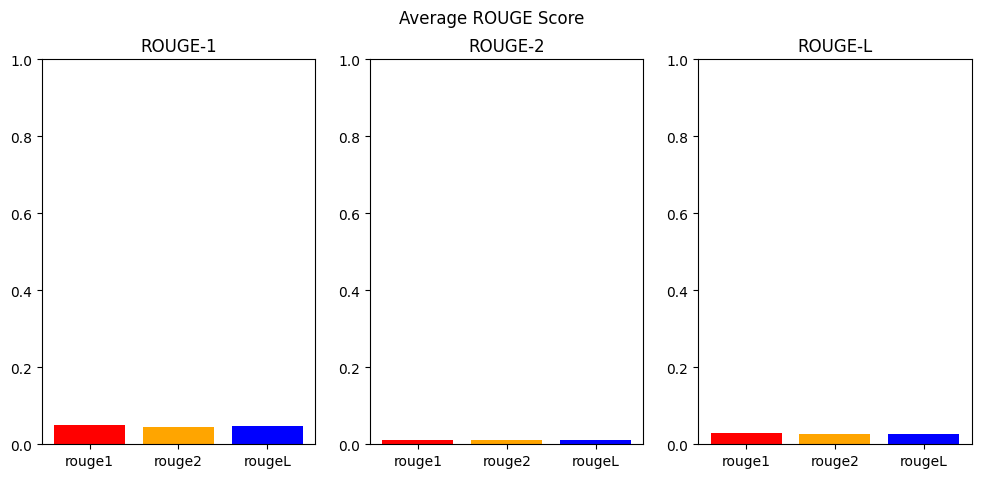

In [121]:
# Plot summed ROUGE score
# Calculate average ROUGE score (n=10)
summed_ROUGE['rouge1']['precision'] /= 10
summed_ROUGE['rouge1']['recall'] /= 10
summed_ROUGE['rouge1']['fmeasure'] /= 10
summed_ROUGE['rouge2']['precision'] /= 10
summed_ROUGE['rouge2']['recall'] /= 10
summed_ROUGE['rouge2']['fmeasure'] /= 10
summed_ROUGE['rougeL']['precision'] /= 10
summed_ROUGE['rougeL']['recall'] /= 10
summed_ROUGE['rougeL']['fmeasure'] /= 10

# Plot summed ROUGE score in dict format
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].bar(scores.keys(), [summed_ROUGE['rouge1']['precision'], summed_ROUGE['rouge1']['recall'], summed_ROUGE['rouge1']['fmeasure']], color=['red', 'orange', 'blue'])
ax[0].set_title('ROUGE-1')
ax[0].set_ylim(0, 1)
ax[1].bar(scores.keys(), [summed_ROUGE['rouge2']['precision'], summed_ROUGE['rouge2']['recall'], summed_ROUGE['rouge2']['fmeasure']], color=['red', 'orange', 'blue'])
ax[1].set_title('ROUGE-2')
ax[1].set_ylim(0, 1)
ax[2].bar(scores.keys(), [summed_ROUGE['rougeL']['precision'], summed_ROUGE['rougeL']['recall'], summed_ROUGE['rougeL']['fmeasure']], color=['red', 'orange', 'blue'])
ax[2].set_title('ROUGE-L')
ax[2].set_ylim(0, 1)
fig.suptitle("Average ROUGE Score")
fig.savefig("Data/plot/plot-sum.png")
